In [1]:
from datetime import datetime, timezone, timedelta
import pandas as pd
from io import StringIO
import import_ipynb
from evaluation import to_timestamp, request_influxdb, query_data, histplots, boxplots, lineplots, missing_data, correlation


importing Jupyter notebook from evaluation.ipynb


In [2]:
# Load Tangaras
tangaras = pd.read_csv('../data/tangaras.csv')
tangaras.shape

(22, 6)

In [3]:
# Start Date Time ISO 8601 Format, TZ='America/Bogota' -05:00
#start_timestamp = to_timestamp('2023-03-17T00:00:00-05:00')
start_timestamp = to_timestamp('2023-04-03T00:00:00-05:00')
# End Date Time ISO 8601 Format, TZ='America/Bogota' -05:00
#end_timestamp = to_timestamp('2023-03-31T00:00:00-05:00')
end_timestamp = to_timestamp('2023-04-04T00:00:00-05:00')

print(f'Since: {start_timestamp} Until: {end_timestamp}')


Since: 1680498000000 Until: 1680584400000


In [4]:
# Get Data Frame Sensors
def df_sensors(tangaras, start_timestamp, end_timestamp):
    # Data Frame Sensors
    df_sensors = []
    # SQL Query Data Sensors
    query = query_data(tangaras, start_timestamp, end_timestamp, datatype='hum')
    # InfluxDB API REST Request
    influxdb_request = request_influxdb(query)
    #print(influxdb_request)
    #print(influxdb_request.text)

    # Data Frame InfluxDB Sensors
    df_influxdb_sensors = pd.read_csv(StringIO(influxdb_request.text), sep=",", low_memory=False)

    # Remove/Add Columns
    df_influxdb_sensors = df_influxdb_sensors[['time', 'name.1', 'last']]
    df_influxdb_sensors.rename(columns={'time': 'DATETIME', 'name.1': 'MAC', 'last': 'HUM'}, inplace=True)

    # Truncate Response
    for index, row in tangaras.iterrows():
        df_sensor = df_influxdb_sensors.loc[df_influxdb_sensors['MAC'] == row['MAC']].reset_index(drop=True)[['DATETIME', 'HUM']] # Warning
        if not df_sensor.empty:
            df_sensor.rename(columns={'HUM': row['ID']}, inplace=True)
            df_sensor.set_index('DATETIME', inplace=True)
            df_sensors.append(df_sensor)
    
    df_sensors = df_sensors[0].join(df_sensors[1:]).reset_index()

    # Date Time ISO 8601 Format, TZ='America/Bogota' -05:00
    tz = timezone(timedelta(hours=-5))
    df_sensors['DATETIME'] = df_sensors['DATETIME'].apply(lambda x: datetime.fromtimestamp(int(x) / 1000, tz=tz).isoformat())
    df_sensors['DATETIME'] = pd.to_datetime(df_sensors['DATETIME'])

    # Set Index
    df_sensors.set_index('DATETIME', inplace=True)
    df_sensors = df_sensors.asfreq(freq='30S')

    df_sensors[df_sensors.columns.to_list()] = df_sensors[df_sensors.columns.to_list()].astype('float64')
    
    return df_sensors


In [5]:
# Data Frame Sensors
hum_raw = df_sensors(tangaras, start_timestamp, end_timestamp)
hum_raw.head()

,TANGARA_DD66,TANGARA_E752,TANGARA_260A,TANGARA_4B1A,TANGARA_65F2,TANGARA_D89A,TANGARA_1106,TANGARA_1282,TANGARA_14D6,TANGARA_1A1E,...,TANGARA_2852,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_375E,TANGARA_F212,TANGARA_1712,TANGARA_48C6,TANGARA_F1AE,TANGARA_06BE
DATETIME,,,,,,,,,,,,,,,,,,,,,
2023-04-03 00:00:00-05:00,0.0,77.31,73.86,71.17,69.86,74.61,67.54,NaN,NaN,NaN,...,59.73,65.54,NaN,73.77,NaN,69.97,75.09,NaN,63.02,NaN
2023-04-03 00:00:30-05:00,0.0,76.51,NaN,70.85,70.26,74.27,67.08,60.03,57.50,60.53,...,59.75,65.57,56.94,73.72,62.10,NaN,NaN,98.5,63.02,67.05
2023-04-03 00:01:00-05:00,0.0,76.77,74.20,70.80,NaN,74.00,66.93,59.97,57.48,59.65,...,59.86,65.59,57.04,73.71,62.37,69.26,74.47,98.5,62.95,67.12
2023-04-03 00:01:30-05:00,0.0,76.90,74.28,70.87,70.14,74.17,67.18,60.11,57.53,59.98,...,59.96,65.64,56.78,73.69,62.43,69.53,74.69,98.5,62.86,67.03
2023-04-03 00:02:00-05:00,0.0,77.07,74.28,70.85,70.32,74.21,67.02,60.09,57.53,59.85,...,60.06,65.68,57.25,73.70,62.21,69.65,74.92,98.5,62.67,67.00


# Descriptive Statistics

In [6]:
# Describe Data
hum_raw.describe()

,TANGARA_DD66,TANGARA_E752,TANGARA_260A,TANGARA_4B1A,TANGARA_65F2,TANGARA_D89A,TANGARA_1106,TANGARA_1282,TANGARA_14D6,TANGARA_1A1E,...,TANGARA_2852,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_375E,TANGARA_F212,TANGARA_1712,TANGARA_48C6,TANGARA_F1AE,TANGARA_06BE
count,2763.0,2676.000000,2652.000000,2670.000000,2662.000000,2671.000000,2660.000000,2748.000000,2699.000000,2268.000000,...,2715.000000,2650.000000,2742.000000,2758.000000,2695.000000,2677.000000,2674.000000,2735.000000,2734.000000,2728.000000
mean,0.0,63.268064,67.462670,59.029236,64.816304,64.244545,59.796568,55.700495,53.990600,54.642478,...,55.843768,60.842804,54.210117,62.847810,56.136686,58.134957,62.423702,92.799817,57.550260,57.215674
std,0.0,11.249612,6.321337,10.378512,5.740796,10.001092,7.853863,9.374848,6.769958,11.774593,...,10.538538,6.355625,4.755215,9.857704,13.941152,9.306644,10.553684,7.689327,8.676867,9.271904
min,0.0,41.310000,51.360000,39.470000,49.720000,42.920000,41.810000,35.550000,43.290000,33.550000,...,41.620000,42.050000,42.120000,45.100000,32.160000,39.210000,41.720000,76.500000,42.700000,42.160000
25%,0.0,54.740000,63.120000,51.322500,62.100000,57.410000,53.775000,48.000000,47.635000,42.960000,...,45.365000,55.720000,51.710000,53.930000,44.970000,51.210000,54.182500,88.100000,49.200000,48.647500
50%,0.0,63.060000,68.685000,58.130000,65.370000,65.560000,61.350000,56.130000,52.790000,55.195000,...,52.960000,61.495000,56.545000,62.255000,54.240000,57.560000,60.855000,95.100000,57.665000,55.290000
75%,0.0,76.300000,73.680000,71.280000,70.000000,74.550000,67.620000,64.040000,60.810000,66.802500,...,67.010000,66.610000,57.400000,73.710000,70.310000,68.910000,74.927500,99.900000,66.617500,67.390000
max,0.0,78.410000,75.260000,72.780000,71.350000,76.780000,69.430000,70.880000,63.660000,70.910000,...,72.800000,68.770000,62.530000,77.110000,77.300000,71.280000,77.330000,99.900000,70.610000,72.280000


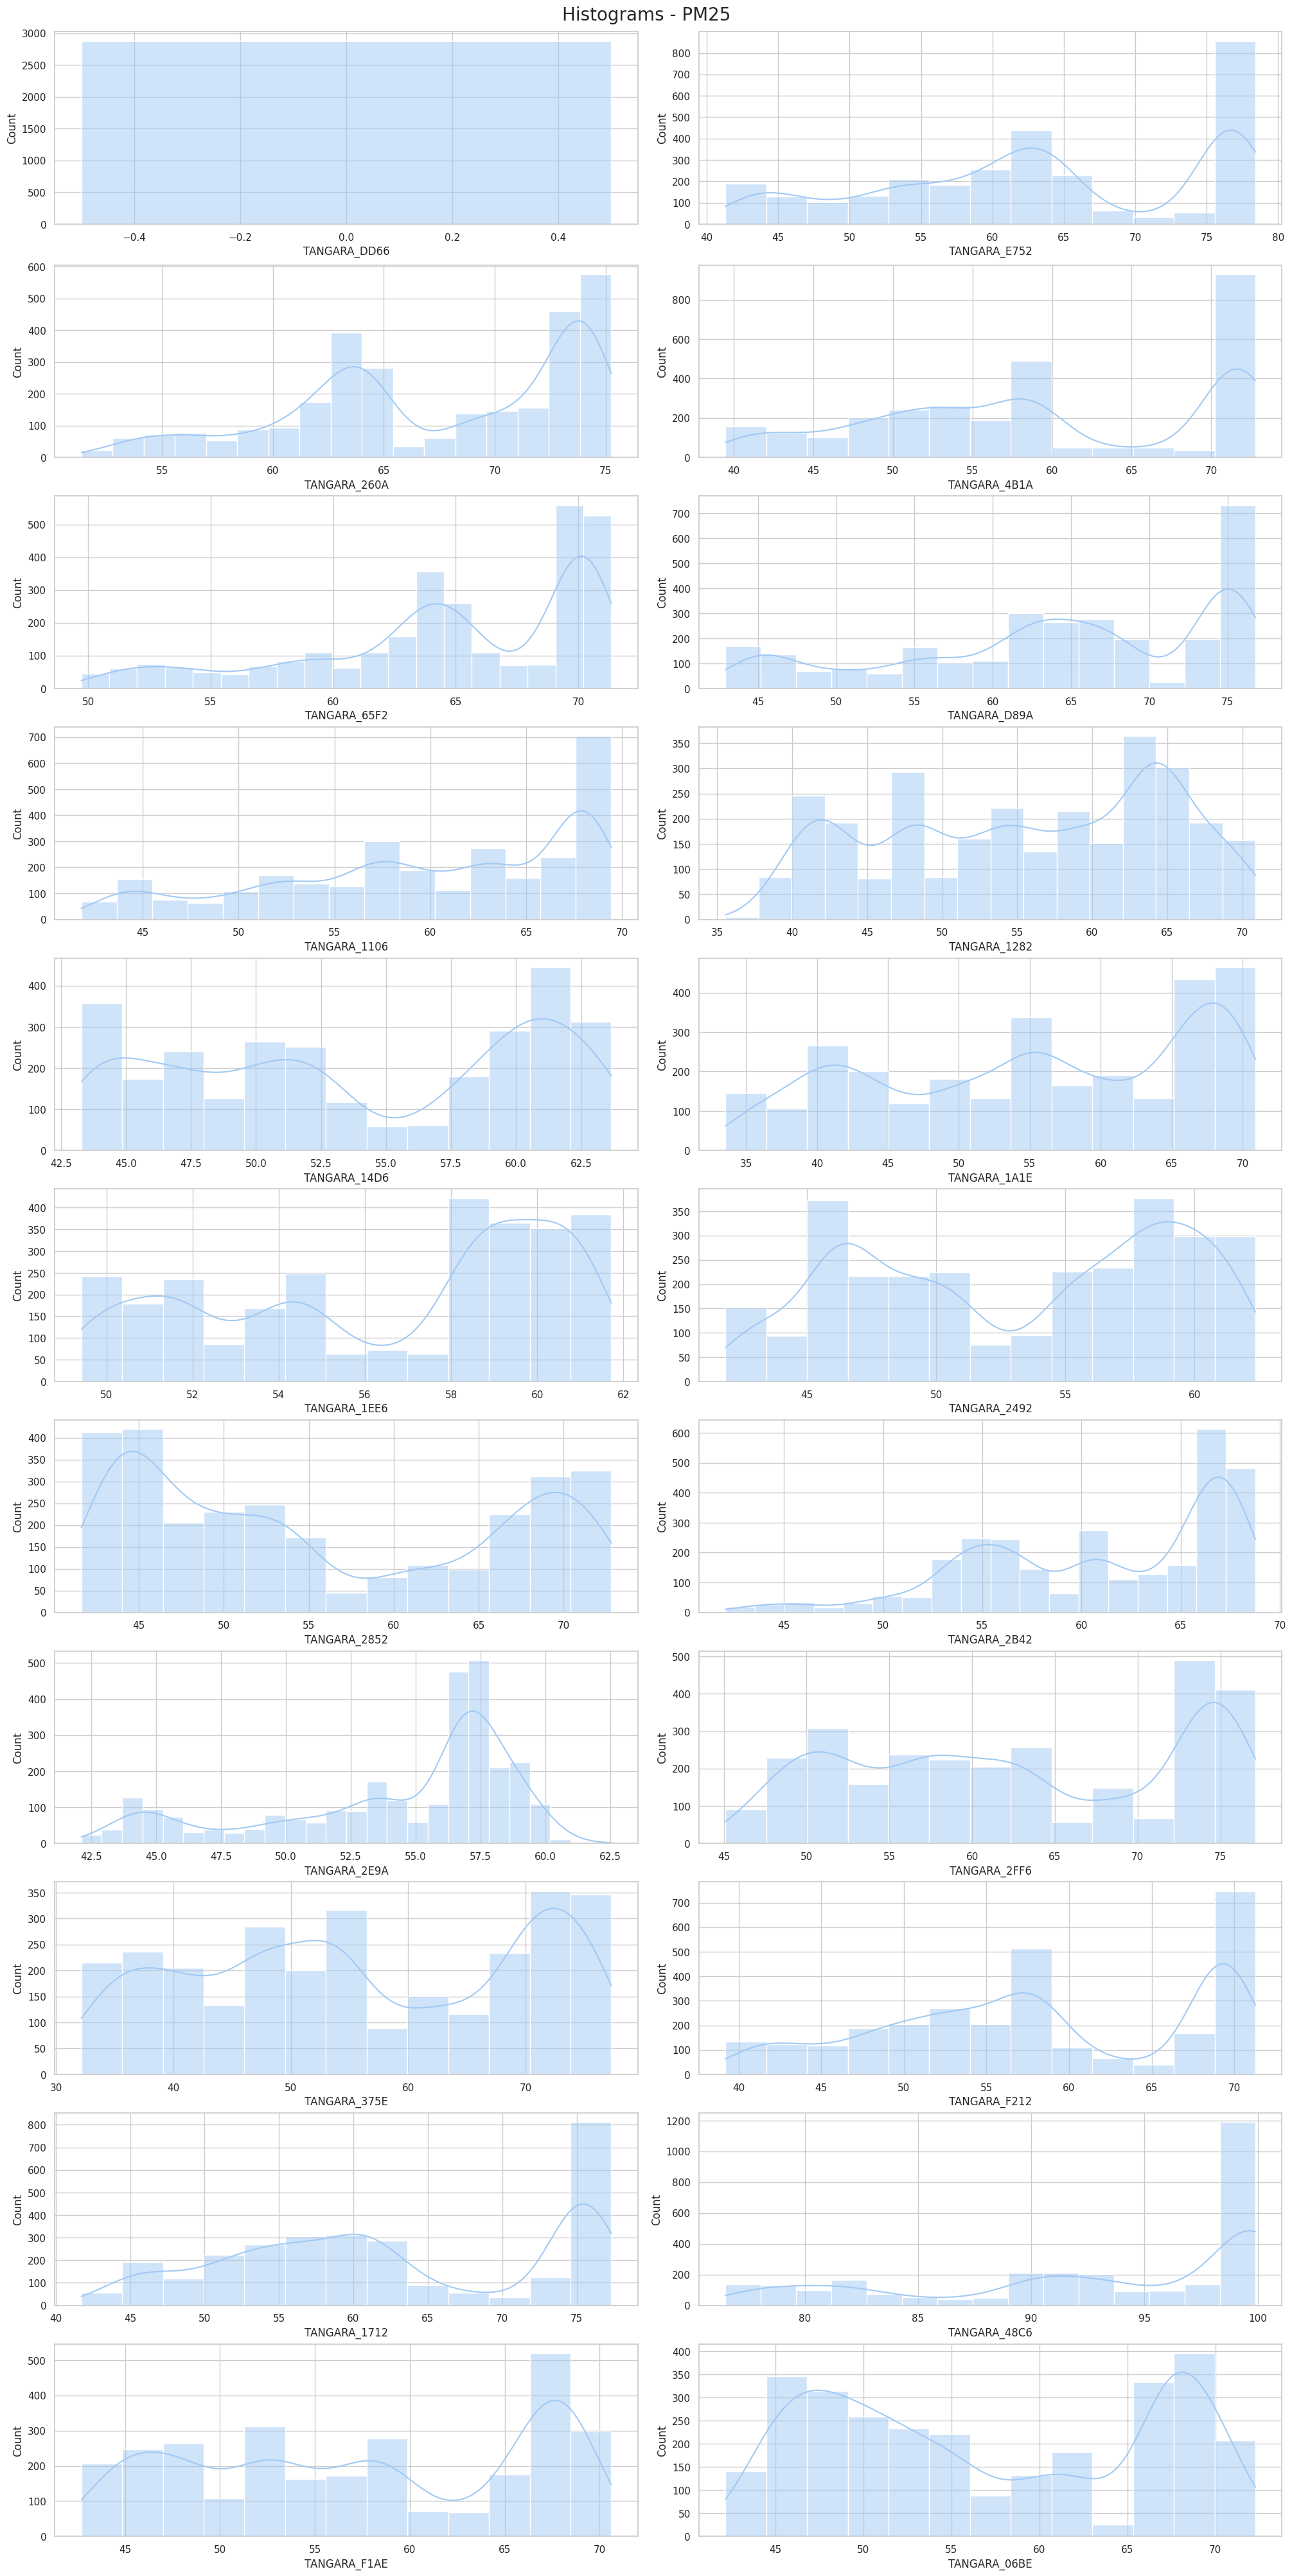

In [7]:
# Plot Humidity Histograms
histplots(hum_raw)

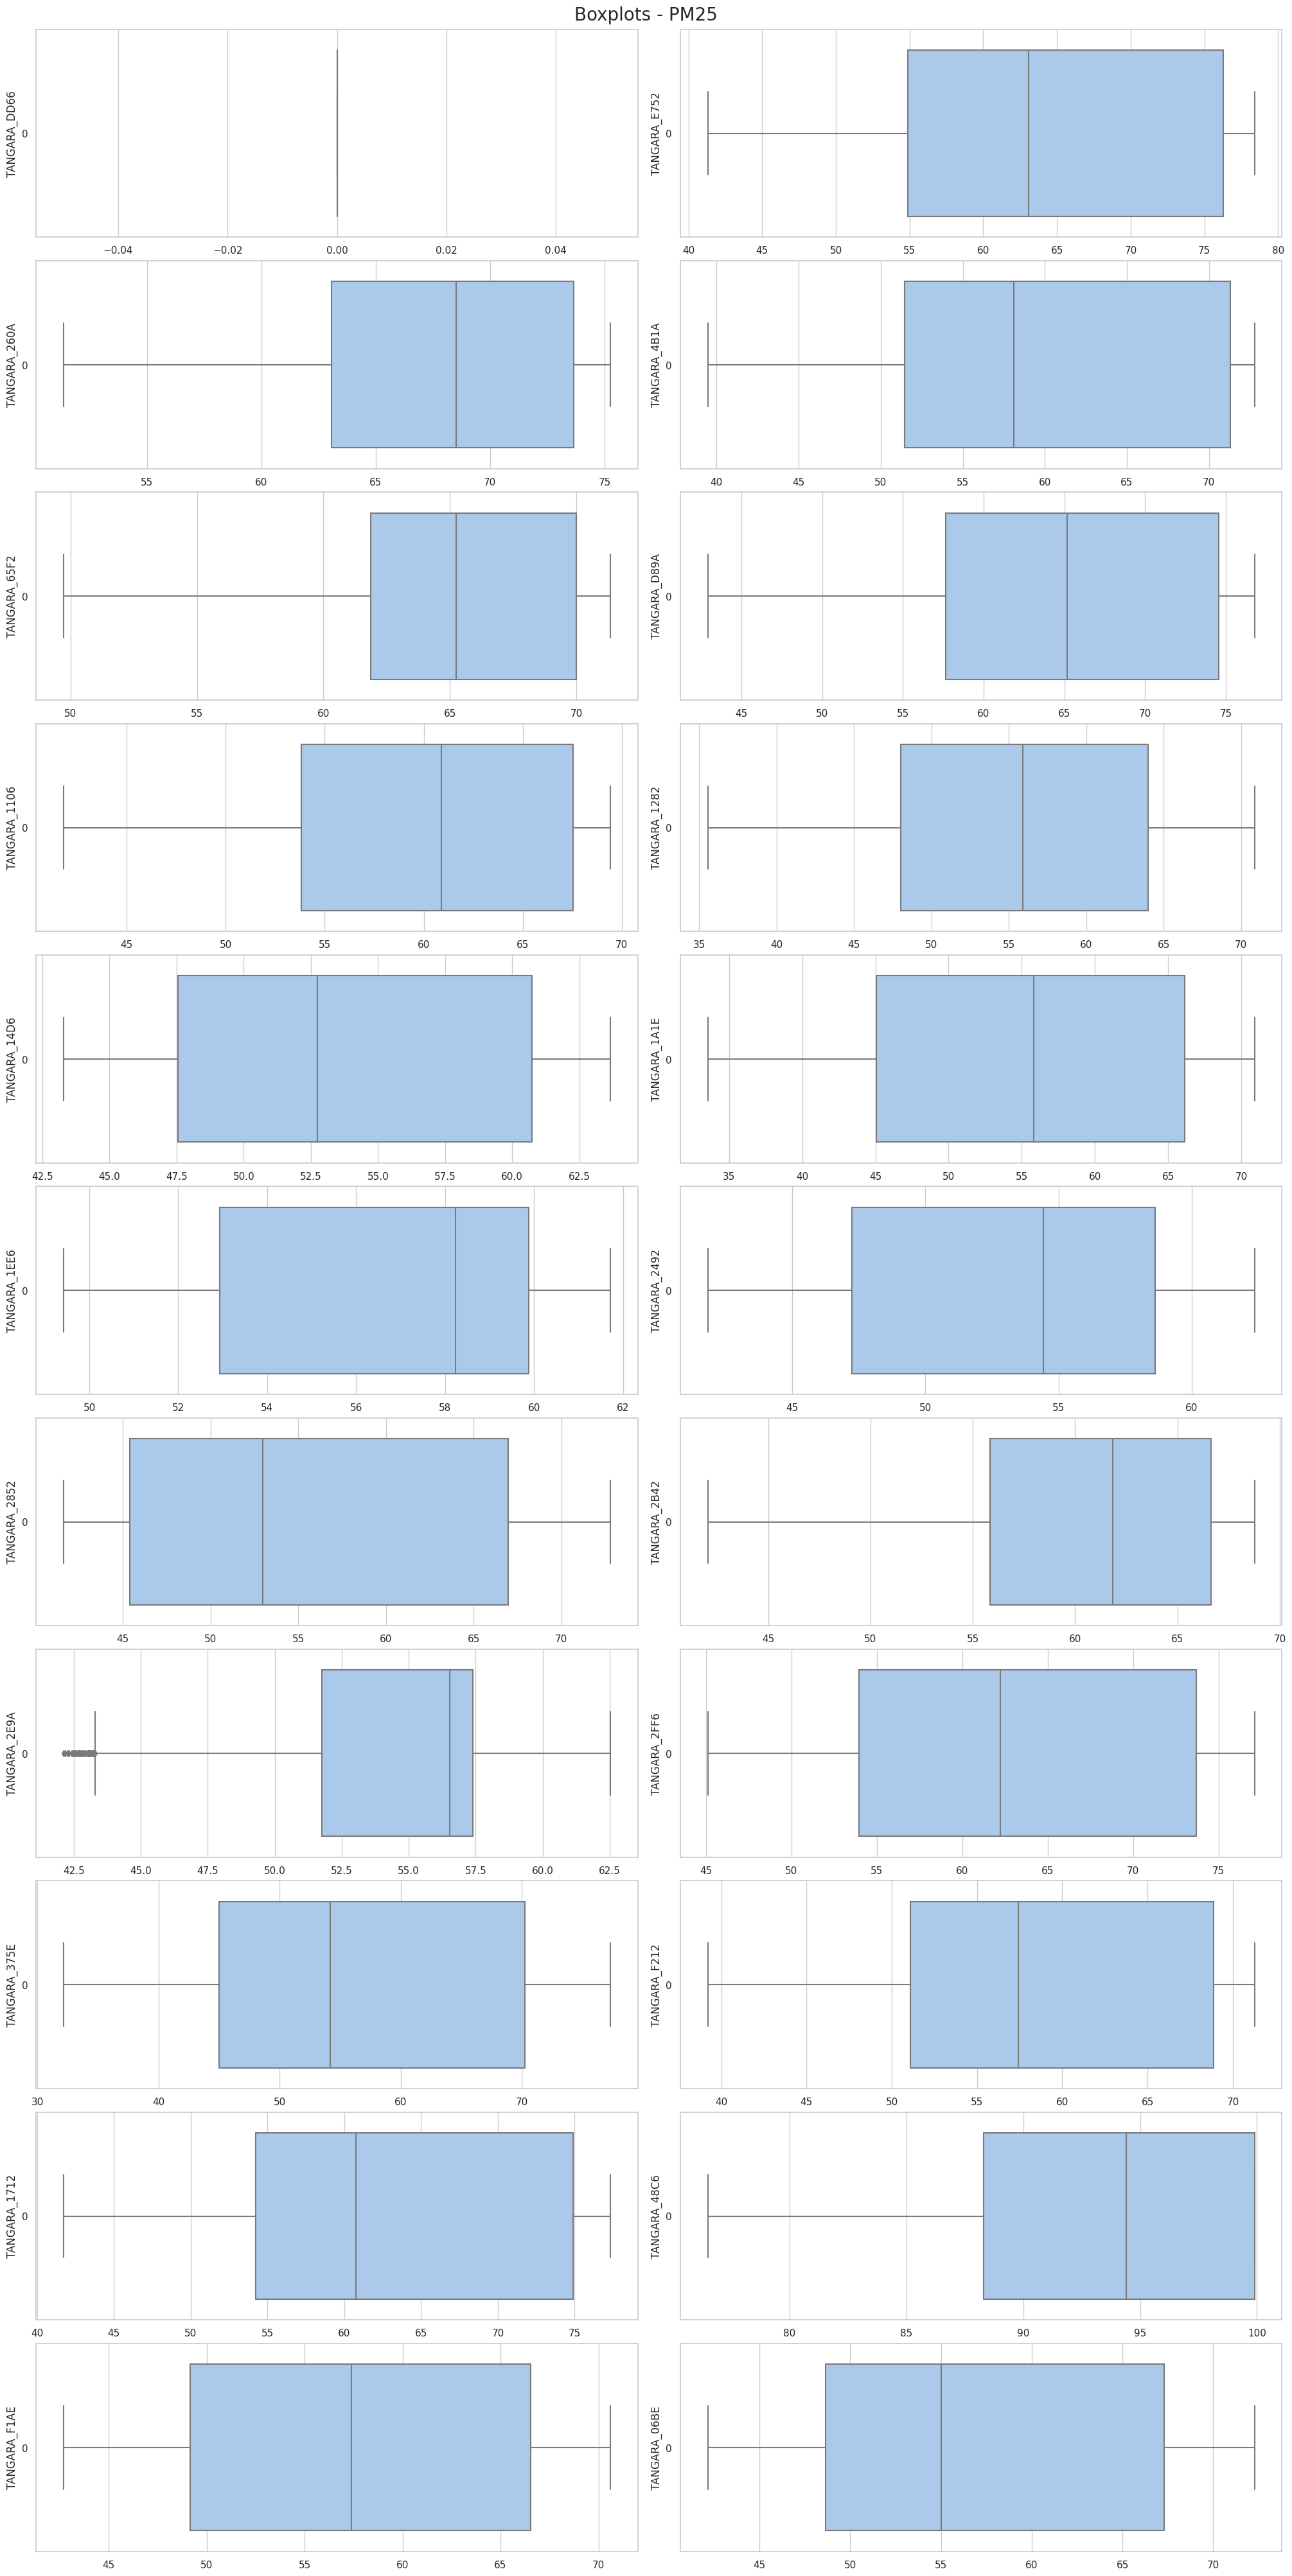

In [8]:
# Plot Humidity Boxplots
boxplots(hum_raw)

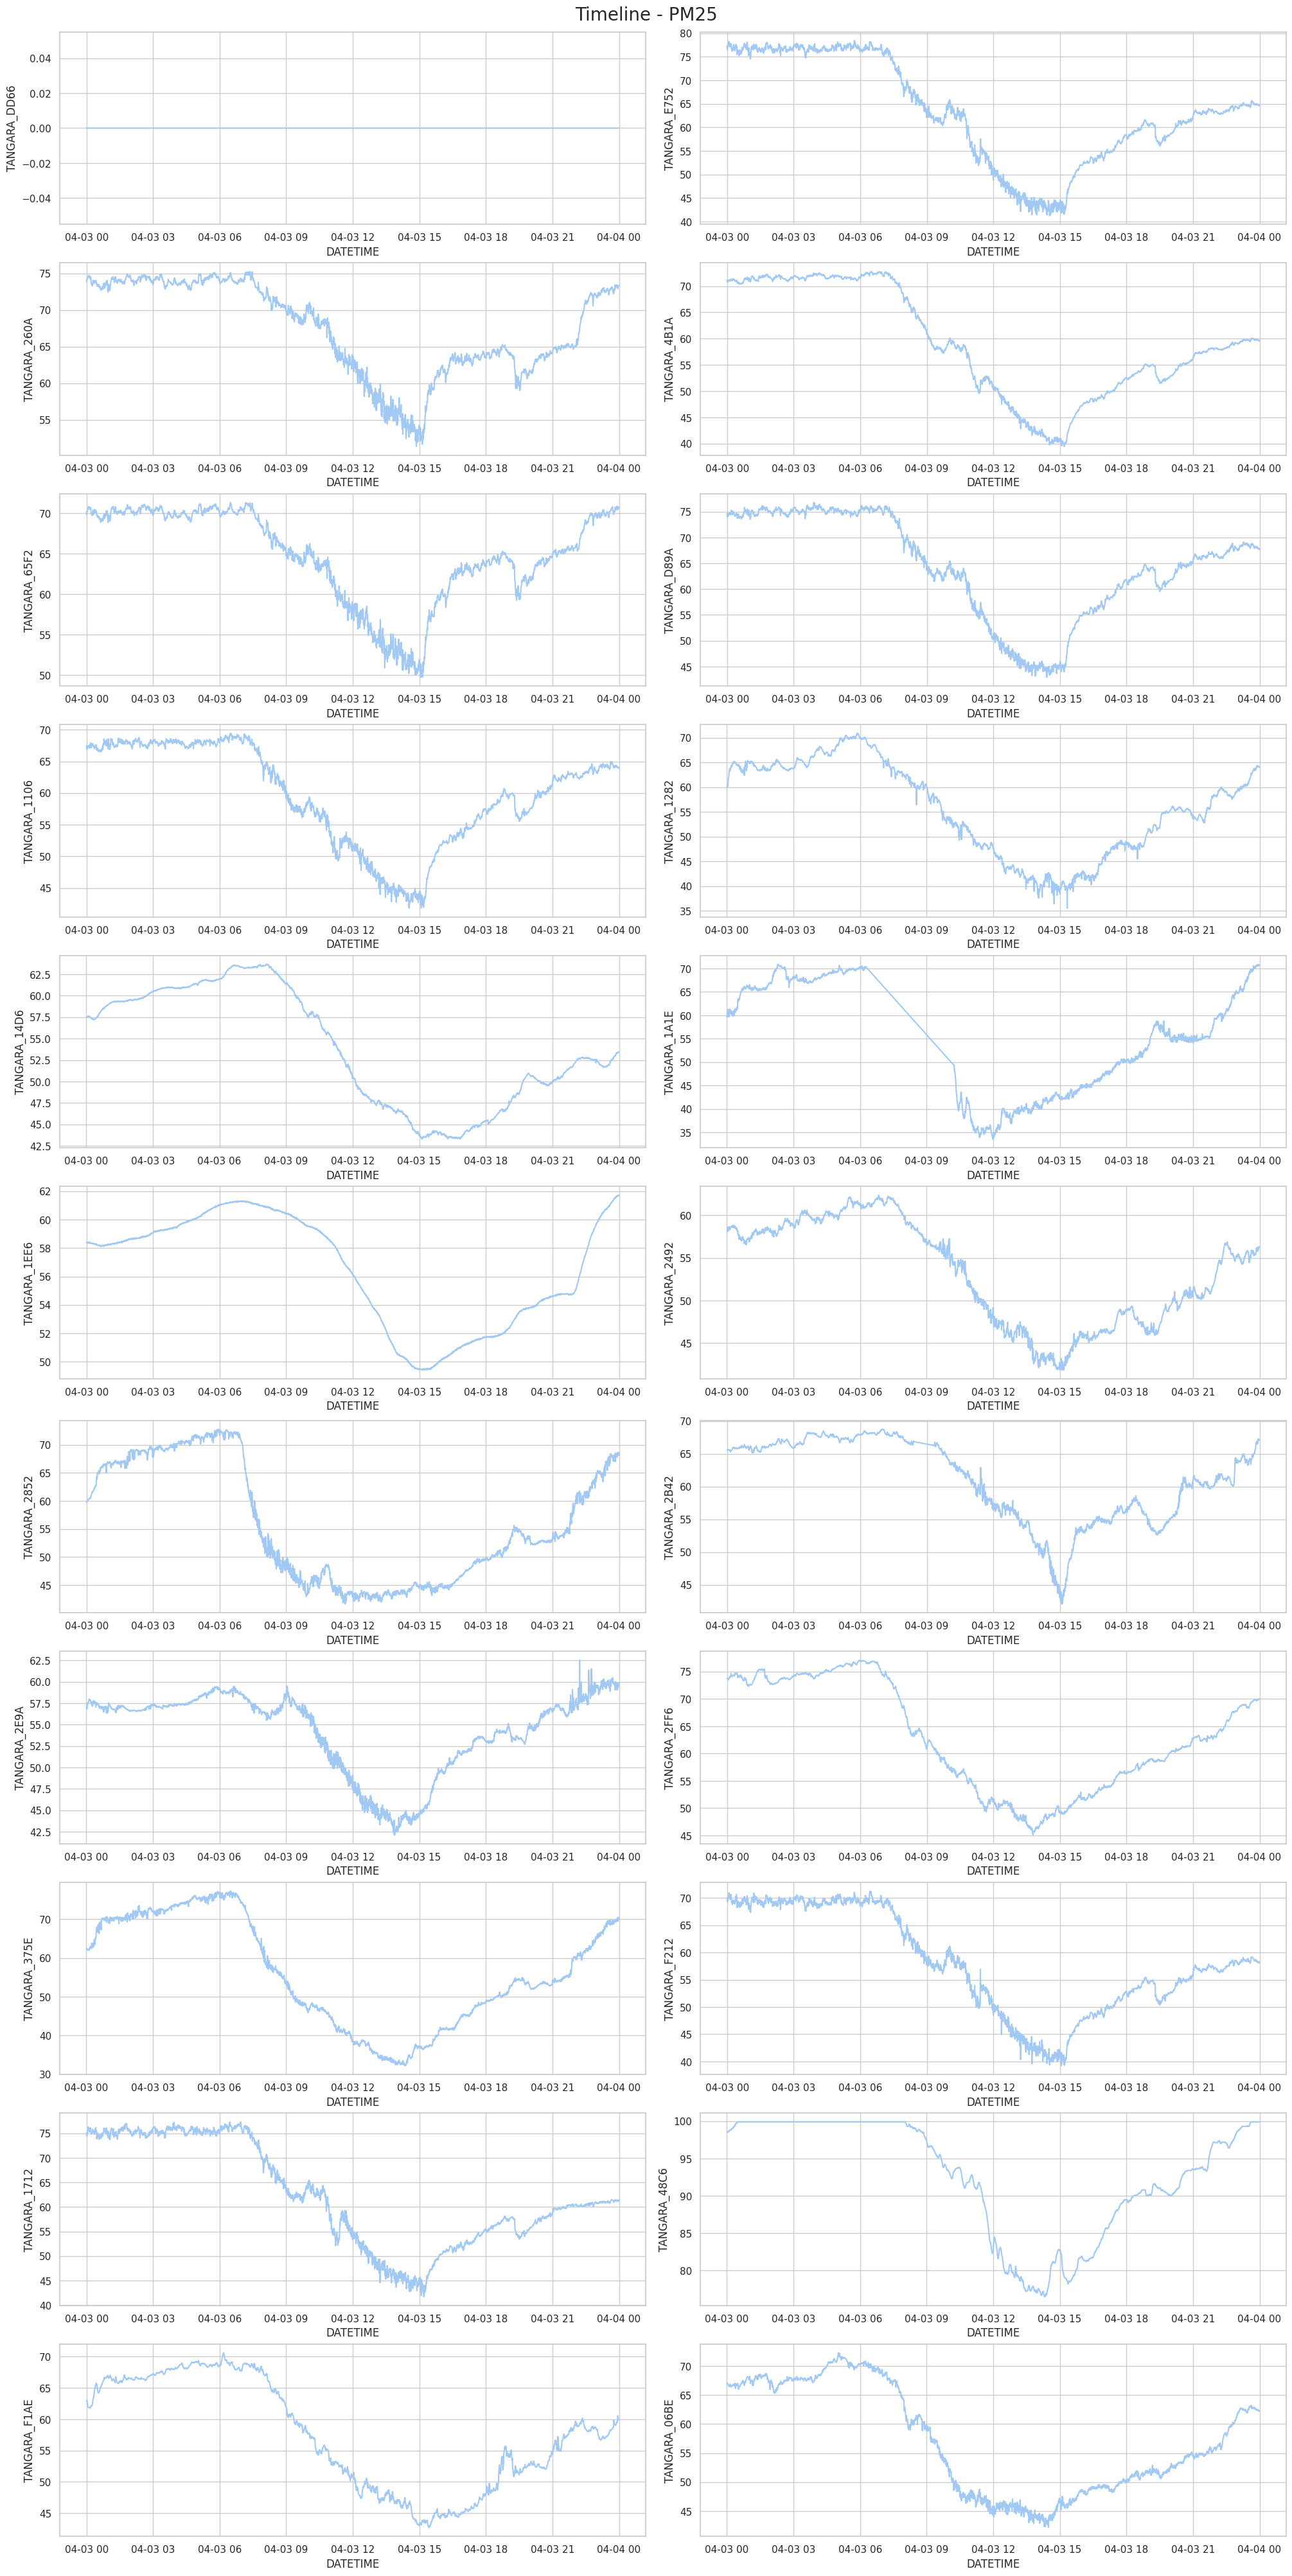

In [9]:
# Plot Humidity Lineplots
lineplots(hum_raw)

In [10]:
# Missing Data Sensors
threshold = 85
to_be_checked = missing_data(hum_raw, threshold)

print(f'Threshold: {threshold}%')
print(f'Total Sensors: {len(hum_raw.columns)}')
print(f'To Be Checked: {len(to_be_checked)}')
to_be_checked

Threshold: 85%
Total Sensors: 22
To Be Checked: 1


[{'ID': 'TANGARA_1A1E', 'Data': '79%', 'Missing': '21%'}]

In [11]:
# Sensors to evaluate by Pearson correlation coefficient
sensors_to_evaluate = hum_raw[['TANGARA_DD66', 'TANGARA_E752', 'TANGARA_4B1A', 'TANGARA_D89A', 'TANGARA_1106', 'TANGARA_F212', 'TANGARA_1712']]

# Pearson correlation coefficient
threshold = 0.7
to_be_checked = correlation(sensors_to_evaluate, 'TANGARA_D89A', threshold)

# Correlation Sensors
print(f'Threshold: {threshold}')
print(f'Total Sensors: {len(sensors_to_evaluate.columns)}')
print(f'To Be Checked: {len(to_be_checked)}')
to_be_checked


Threshold: 0.7
Total Sensors: 7
To Be Checked: 1


[{'Reference': {'ID': 'TANGARA_D89A', 'Data': 2880, 'Freq': <30 * Seconds>},
  'Target': {'ID': 'TANGARA_DD66', 'Data': 2880, 'Freq': <30 * Seconds>},
  'Correlation': 0}]

In [12]:
# Save Humidity raw data into CSV file
hum_raw.to_csv('../data/hum_raw.csv')